<a href="https://colab.research.google.com/github/GeorgeSherif/NLP-ChatEGP/blob/main/Model%20Before%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing & Importing the Necessary Libraries and Mounting the drive**

In [3]:
!pip3 install transformers sentencepiece protobuf torch pygal torchvision sacremoses


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.29.2-py3-none-any.whl (7.1 MB)
  Using cached sentencepiece-0.1.99-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached pygal-3.0.0-py2.py3-none-any.whl (129 kB)
  Using cached sacremoses-0.0.53.tar.gz (880 kB)
  Preparing metadata (setup.py) ... done
  Using cached huggingface_hub-0.14.1-py3-none-any.whl (224 kB)
  Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=ee5928e5a1c15eb5778554a0707eb7299e6db3aaed9d6d1455969bc0dcad9a0e
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses


In [4]:
from google.colab import drive
from IPython.display import display # Allows the use of display() for DataFrames
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [5]:
import pandas as pd
import numpy as np
import os
import warnings
import csv
import re
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import pygal as py
import matplotlib
plt.rcParams["figure.figsize"] = (8,5)
matplotlib.rc('xtick', labelsize=7) 
matplotlib.rc('ytick', labelsize=7) 

import torch
import torchvision

from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline 

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# **Approach 1: Evaluate the English Model (BERT)**


*   English Train Data
*   Arabic Test Data
*   Train with the English Dataset
*   Translate the Arabic Dataset
*   Evaluate Model





### Load the English Dataset

In [7]:
df = pd.read_csv('/content/gdrive/MyDrive/NLP/English Dataset.csv' ,engine="python", encoding = "ISO-8859-1")
#df = pd.read_csv('/content/gdrive/MyDrive/NLP/preprocessed.csv' ,engine="python", encoding = "ISO-8859-1")
print((df['Sentiment'] == 'neutral').sum())


2879


In [8]:
num_entries_to_remove_positive = (df['Sentiment'] == 'positive').sum() - (df['Sentiment'] == 'negative').sum()
num_entries_to_remove_neutral = (df['Sentiment'] == 'neutral').sum() - (df['Sentiment'] == 'negative').sum()
print(num_entries_to_remove_neutral)


indices_to_remove = df[df['Sentiment'] == 'positive'].sample(num_entries_to_remove_positive).index
dfPositive = df[df['Sentiment'] == 'positive'].drop(indices_to_remove)

indices_to_remove = df[df['Sentiment'] == 'neutral'].sample(num_entries_to_remove_neutral).index
dfNeutral = df[df['Sentiment'] == 'neutral'].drop(indices_to_remove)

indices_to_remove = df[df['Sentiment'] == 'negative'].sample(0).index
dfNegative = df[df['Sentiment'] == 'negative'].drop(indices_to_remove)

print(dfNegative)

2275
     Sentiment                                           Sentence
2     negative  The international electronic industry company ...
415   negative  A tinyurl link takes users to a scamming site ...
421   negative  Compared with the FTSE 100 index , which rose ...
423   negative  Compared with the FTSE 100 index , which rose ...
500   negative  One of the challenges in the oil production in...
...        ...                                                ...
4840  negative  HELSINKI Thomson Financial - Shares in Cargote...
4841  negative  LONDON MarketWatch -- Share prices ended lower...
4843  negative  Operating profit fell to EUR 35.4 mn from EUR ...
4844  negative  Net sales of the Paper segment decreased to EU...
4845  negative  Sales in Finland decreased by 10.5 % in Januar...

[604 rows x 2 columns]


In [9]:
dfNew = pd.concat((dfNegative, dfNeutral, dfPositive), axis = 0)
dfNew
df = dfNew

In [10]:
df['Sentiment'] = df['Sentiment'].replace(['negative','neutral','positive'],[0,1,2])
df

,Sentiment,Sentence
2,0,The international electronic industry company ...
415,0,A tinyurl link takes users to a scamming site ...
421,0,"Compared with the FTSE 100 index , which rose ..."
423,0,"Compared with the FTSE 100 index , which rose ..."
500,0,One of the challenges in the oil production in...
...,...,...
4592,2,"In the fourth quarter of 2009 , Atria 's net l..."
4773,2,"According to the company , its operating profi..."
4780,2,"The antibody , given at repeated doses of up t..."
4786,2,Danske Bank A-S DANSKE DC jumped 3.7 percent t...


<Axes: xlabel='count', ylabel='Sentiment'>

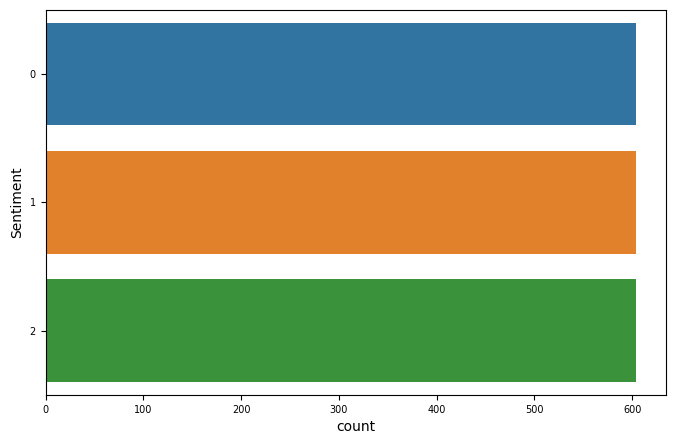

In [11]:
sns.countplot(y="Sentiment",data=df)

In [12]:
df.drop_duplicates(subset=['Sentence'],keep='first',inplace=True)
df

,Sentiment,Sentence
2,0,The international electronic industry company ...
415,0,A tinyurl link takes users to a scamming site ...
421,0,"Compared with the FTSE 100 index , which rose ..."
423,0,"Compared with the FTSE 100 index , which rose ..."
500,0,One of the challenges in the oil production in...
...,...,...
4592,2,"In the fourth quarter of 2009 , Atria 's net l..."
4773,2,"According to the company , its operating profi..."
4780,2,"The antibody , given at repeated doses of up t..."
4786,2,Danske Bank A-S DANSKE DC jumped 3.7 percent t...


### Sentiment Analysis using BERT

In [15]:
from sklearn.model_selection import train_test_split
X_features = df["Sentence"]
Y_features = df["Sentiment"]
X_train, X_val, y_train, y_val = train_test_split(df.index.values, df.Sentiment.values, test_size=0.2, random_state=42, shuffle=True)

In [14]:
from transformers import BertTokenizer,BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 3,
                                                      id2label={0: 'negative', 1: 'neutral', 2: 'positive'},
                                                      output_attentions = False,
                                                      output_hidden_states = False).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [16]:
df['data_type'] = ['not_set'] * df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

#groupby count
df.groupby([ 'Sentiment', 'data_type']).count()
#df = df.rename(columns={'Review Text': 'Sentence'})
df[df.data_type == 'train'].Sentence.values


array(['The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .',
       'A tinyurl link takes users to a scamming site promising that users can earn thousands of dollars by becoming a Google ( NASDAQ : GOOG ) Cash advertiser .',
       'Compared with the FTSE 100 index , which rose 36.7 points ( or 0.6 % ) on the day , this was a relative price change of -0.2 % .',
       ...,
       'According to the company , its operating profit , excluding non-recurring items , in the fourth quarter of 2009 was significantly better than expected , and also better than the figures for the fourth quarter of 2008 .',
       'The antibody , given at repeated doses of up to 8 mg-kg , was generally well tolerated , and the pharmacokinetic characteristics of BTT-1023 in psoriasis patients were consistent with those observed in a previ

In [17]:
#encode train set
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].Sentence.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                 truncation=True,
                                                return_tensors = 'pt')
                                                
#encode validation set
encoded_data_val = tokenizer.batch_encode_plus( df[df.data_type == 'val'].Sentence.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                               truncation=True,
                                                return_tensors = 'pt')

In [18]:
#train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].Sentiment.values)

#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].Sentiment.values)
     

In [19]:
from torch.utils.data import TensorDataset

#train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

#validation set
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [20]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = batch_size) #since we don't have to do backpropagation for this step

In [21]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-7) #2e-5 > 5e-5
                 
epochs = 8

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps =len(dataloader_train)*epochs)


In [22]:
def evaluate(dataloader_val):

    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [23]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [24]:
#accuracy score
def accuracy_per_class(preds, labels):
    #label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    correct = 0
    total = 0

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n -> {len(y_preds[y_preds==label]) / len(y_true)}')
        correct = correct + len(y_preds[y_preds==label])
        total = total + len(y_true)
    return correct / total

In [25]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [26]:
from tqdm import tqdm

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    
    for batch in progress_bar:
        
        model.zero_grad() #set gradient to 0
    
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0], 
                  'attention_mask': batch[1], 
                  'labels': batch[2]}
        
        outputs = model(**inputs) #unpack the dict straight into inputs
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'/content/gdrive/MyDrive/NLP/BERT_BeforePreProcessing_ft_epoch{epoch}.model')
    
    tqdm.write('\n Epoch {epoch}')
    
    loss_train_ave = loss_train_total / len(dataloader_train)
    tqdm.write('Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    true_vals.shape
    accuracy = accuracy_per_class(predictions, true_vals)

    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')
    tqdm.write(f'Accuracy Score: {accuracy}')

  0%|          | 0/8 [38:22<?, ?it/s]


 Epoch {epoch}
Training loss: {loss_train_avg}



 12%|█▎        | 1/8 [41:21<4:49:31, 2481.62s/it]

Accuracy:115/132
 -> 0.8712121212121212
Accuracy:93/109
 -> 0.8532110091743119
Accuracy:38/122
 -> 0.3114754098360656
Validation loss: 0.732960137984027
F1 Score (weighted): 0.6516521116025777
Accuracy Score: 0.6776859504132231



 12%|█▎        | 1/8 [1:19:20<4:49:31, 2481.62s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 25%|██▌       | 2/8 [1:22:21<4:06:52, 2468.71s/it]

Accuracy:126/132
 -> 0.9545454545454546
Accuracy:82/109
 -> 0.7522935779816514
Accuracy:89/122
 -> 0.7295081967213115
Validation loss: 0.46545241870309995
F1 Score (weighted): 0.8155438634632886
Accuracy Score: 0.8181818181818182



 25%|██▌       | 2/8 [2:00:16<4:06:52, 2468.71s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 38%|███▊      | 3/8 [2:03:18<3:25:17, 2463.48s/it]

Accuracy:124/132
 -> 0.9393939393939394
Accuracy:81/109
 -> 0.7431192660550459
Accuracy:104/122
 -> 0.8524590163934426
Validation loss: 0.45249405742177495
F1 Score (weighted): 0.8494431956635297
Accuracy Score: 0.8512396694214877



 38%|███▊      | 3/8 [2:41:17<3:25:17, 2463.48s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 50%|█████     | 4/8 [2:44:17<2:44:06, 2461.68s/it]

Accuracy:122/132
 -> 0.9242424242424242
Accuracy:85/109
 -> 0.7798165137614679
Accuracy:96/122
 -> 0.7868852459016393
Validation loss: 0.5104418151364054
F1 Score (weighted): 0.8342957735447797
Accuracy Score: 0.8347107438016529



 50%|█████     | 4/8 [3:22:17<2:44:06, 2461.68s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 62%|██████▎   | 5/8 [3:25:18<2:03:04, 2461.35s/it]

Accuracy:127/132
 -> 0.9621212121212122
Accuracy:82/109
 -> 0.7522935779816514
Accuracy:100/122
 -> 0.819672131147541
Validation loss: 0.5806649488133743
F1 Score (weighted): 0.8491720083538635
Accuracy Score: 0.8512396694214877



 62%|██████▎   | 5/8 [4:03:35<2:03:04, 2461.35s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 75%|███████▌  | 6/8 [4:06:33<1:22:12, 2466.21s/it]

Accuracy:126/132
 -> 0.9545454545454546
Accuracy:84/109
 -> 0.7706422018348624
Accuracy:105/122
 -> 0.860655737704918
Validation loss: 0.5675015134645788
F1 Score (weighted): 0.866475389197324
Accuracy Score: 0.8677685950413223



 75%|███████▌  | 6/8 [4:44:21<1:22:12, 2466.21s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 88%|████████▊ | 7/8 [4:47:18<40:59, 2459.11s/it]  

Accuracy:126/132
 -> 0.9545454545454546
Accuracy:83/109
 -> 0.7614678899082569
Accuracy:104/122
 -> 0.8524590163934426
Validation loss: 0.6130559661213065
F1 Score (weighted): 0.860735228197529
Accuracy Score: 0.8622589531680441



 88%|████████▊ | 7/8 [5:25:11<40:59, 2459.11s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



100%|██████████| 8/8 [5:28:11<00:00, 2461.41s/it]

Accuracy:126/132
 -> 0.9545454545454546
Accuracy:83/109
 -> 0.7614678899082569
Accuracy:103/122
 -> 0.8442622950819673
Validation loss: 0.6096877772867194
F1 Score (weighted): 0.8580271854524925
Accuracy Score: 0.859504132231405


In [27]:
_, predictions, true_vals = evaluate(dataloader_val)

100%|██████████| 46/46 [03:01<00:00,  3.94s/it]


In [28]:
true_vals.shape
accuracy_per_class(predictions, true_vals)

Accuracy:126/132
 -> 0.9545454545454546
Accuracy:83/109
 -> 0.7614678899082569
Accuracy:103/122
 -> 0.8442622950819673


0.859504132231405